In [1]:
!pip install -Uqq nixtla datasetsforecast utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 653.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 2.4 MB/s eta 0:00:00


In [2]:
from nixtla.utils import in_colab

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
IN_COLAB = in_colab()

In [4]:
import pandas as pd
from nixtla import NixtlaClient
from google.colab import userdata
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

In [5]:
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')
nixtla_client = NixtlaClient(
    api_key = NIXTLA_API_KEY
)


# **Multiple series forecasting**

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity.csv')
df.head()

,unique_id,ds,y
0,BE,2011-01-09 00:00:00,32.54
1,BE,2011-01-09 01:00:00,21.55
2,BE,2011-01-09 02:00:00,15.71
3,BE,2011-01-09 03:00:00,10.58
4,BE,2011-01-09 04:00:00,10.32


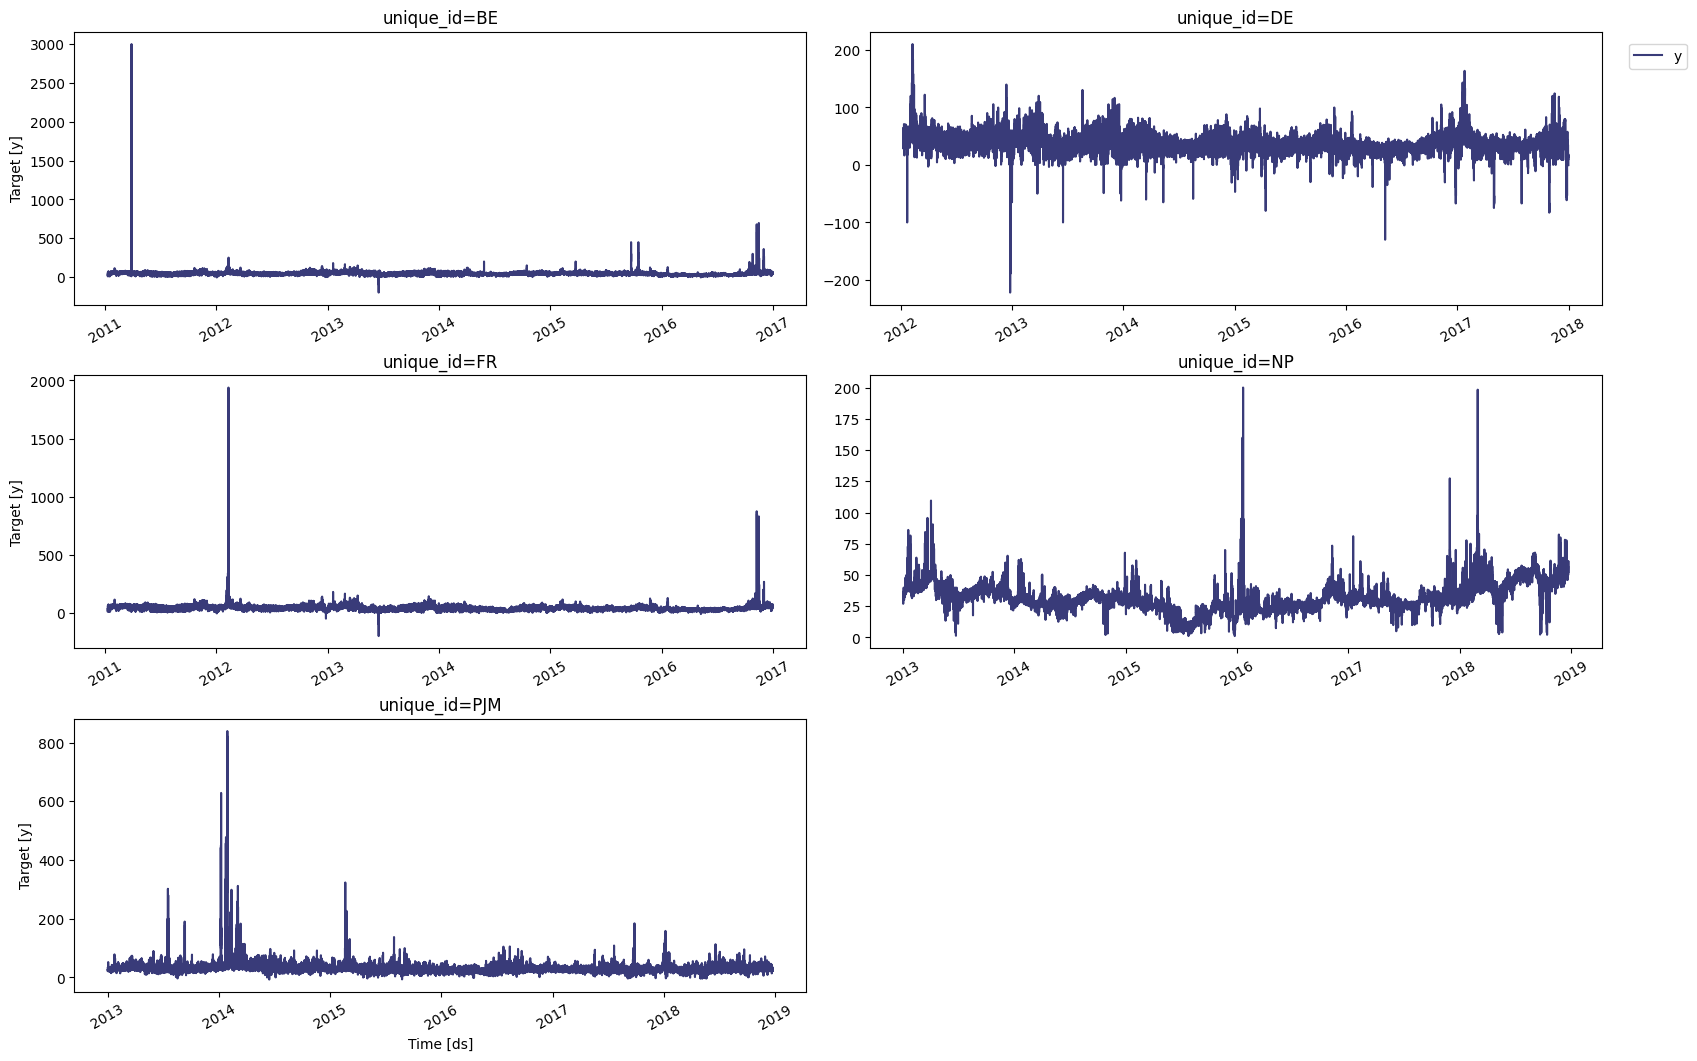

In [11]:
nixtla_client.plot(df)

### **Forecasting Multiple Series**

In [12]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])
timegpt_fcst_multiseries_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,45.191200,54.872765,57.370620,35.509636,33.011780
1,BE,2016-12-31 01:00:00,43.245210,51.114510,56.101950,35.375908,30.388466
2,BE,2016-12-31 02:00:00,41.959000,48.577030,54.632755,35.340970,29.285244
3,BE,2016-12-31 03:00:00,39.797043,47.267212,49.683910,32.326874,29.910175
4,BE,2016-12-31 04:00:00,39.205093,47.410007,47.678200,31.000177,30.731985


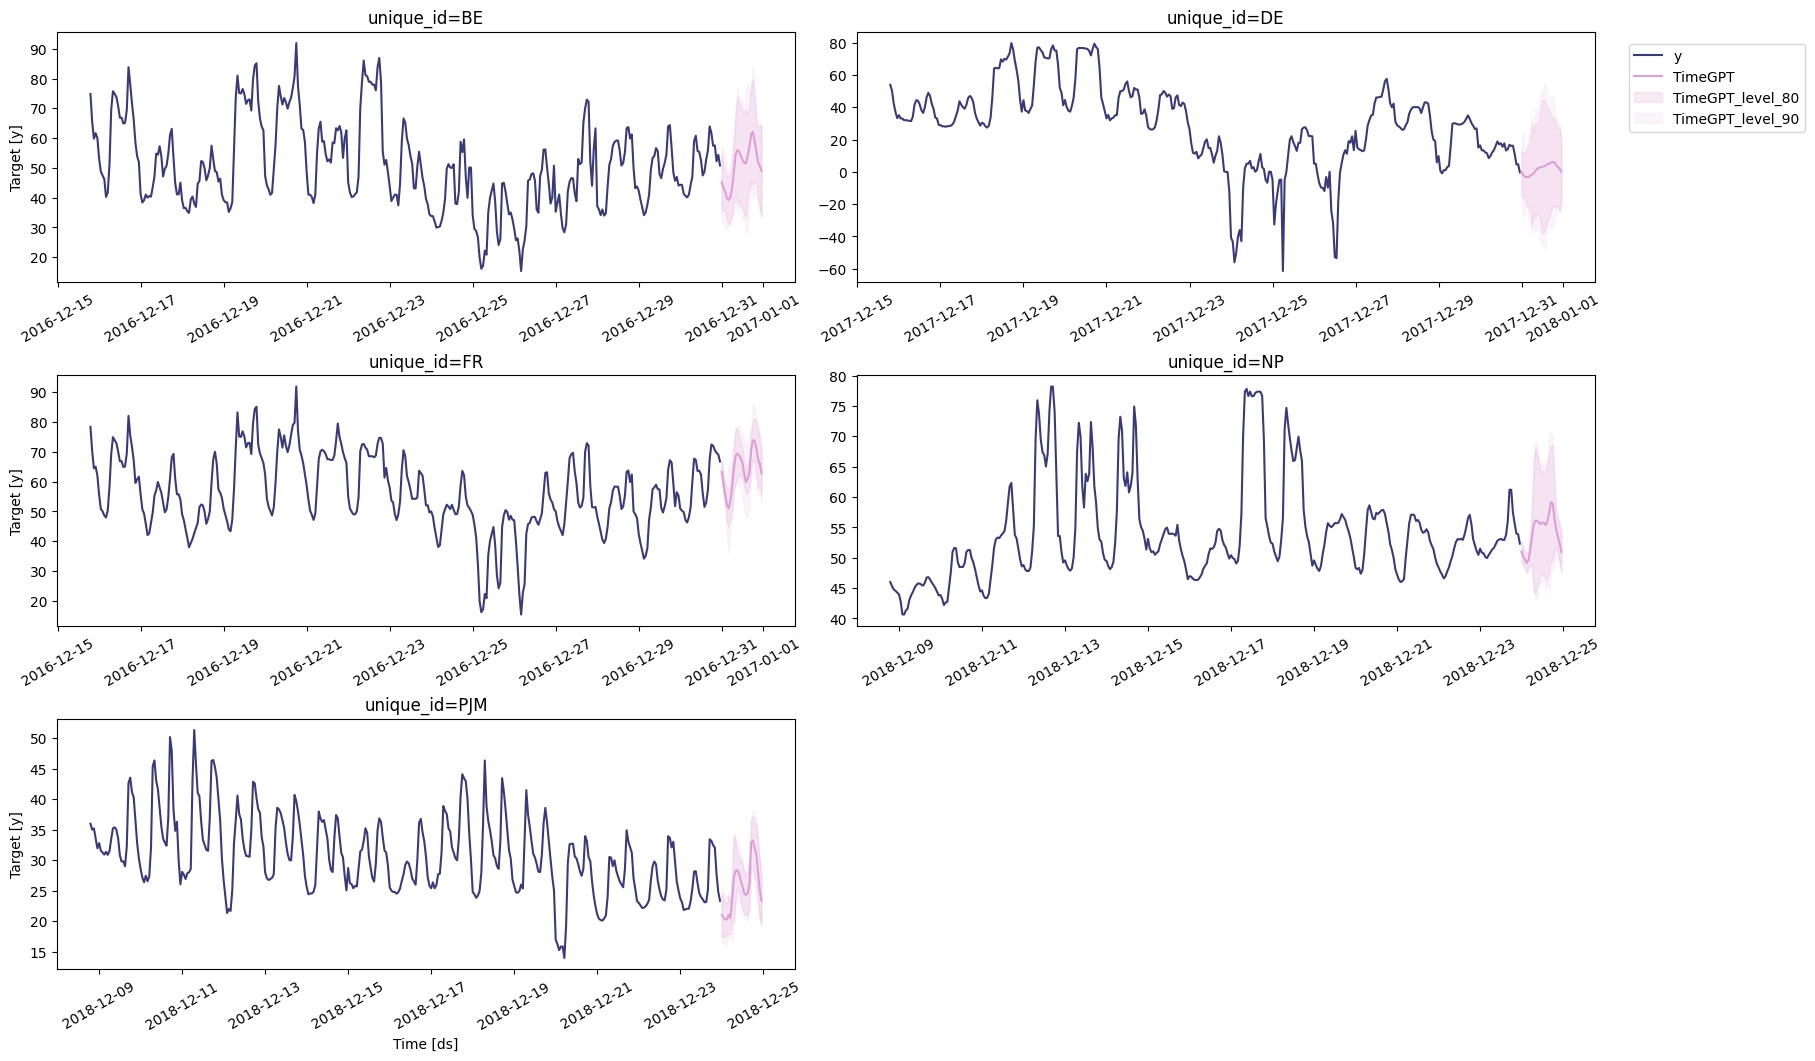

In [13]:
nixtla_client.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90])

### **Historical forecast**

In [14]:
timegpt_fcst_multiseries_with_history_df = nixtla_client.forecast(df=df, h=24, level=[80, 90], add_history=True)
timegpt_fcst_multiseries_with_history_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2011-01-14 00:00:00,35.557600,59.970036,66.890625,11.145162,4.224575
1,BE,2011-01-14 01:00:00,29.692497,54.104935,61.025520,5.280060,-1.640526
2,BE,2011-01-14 02:00:00,22.994167,47.406605,54.327190,-1.418270,-8.338856
3,BE,2011-01-14 03:00:00,15.353025,39.765460,46.686050,-9.059411,-15.979998
4,BE,2011-01-14 04:00:00,14.716946,39.129383,46.049970,-9.695491,-16.616077


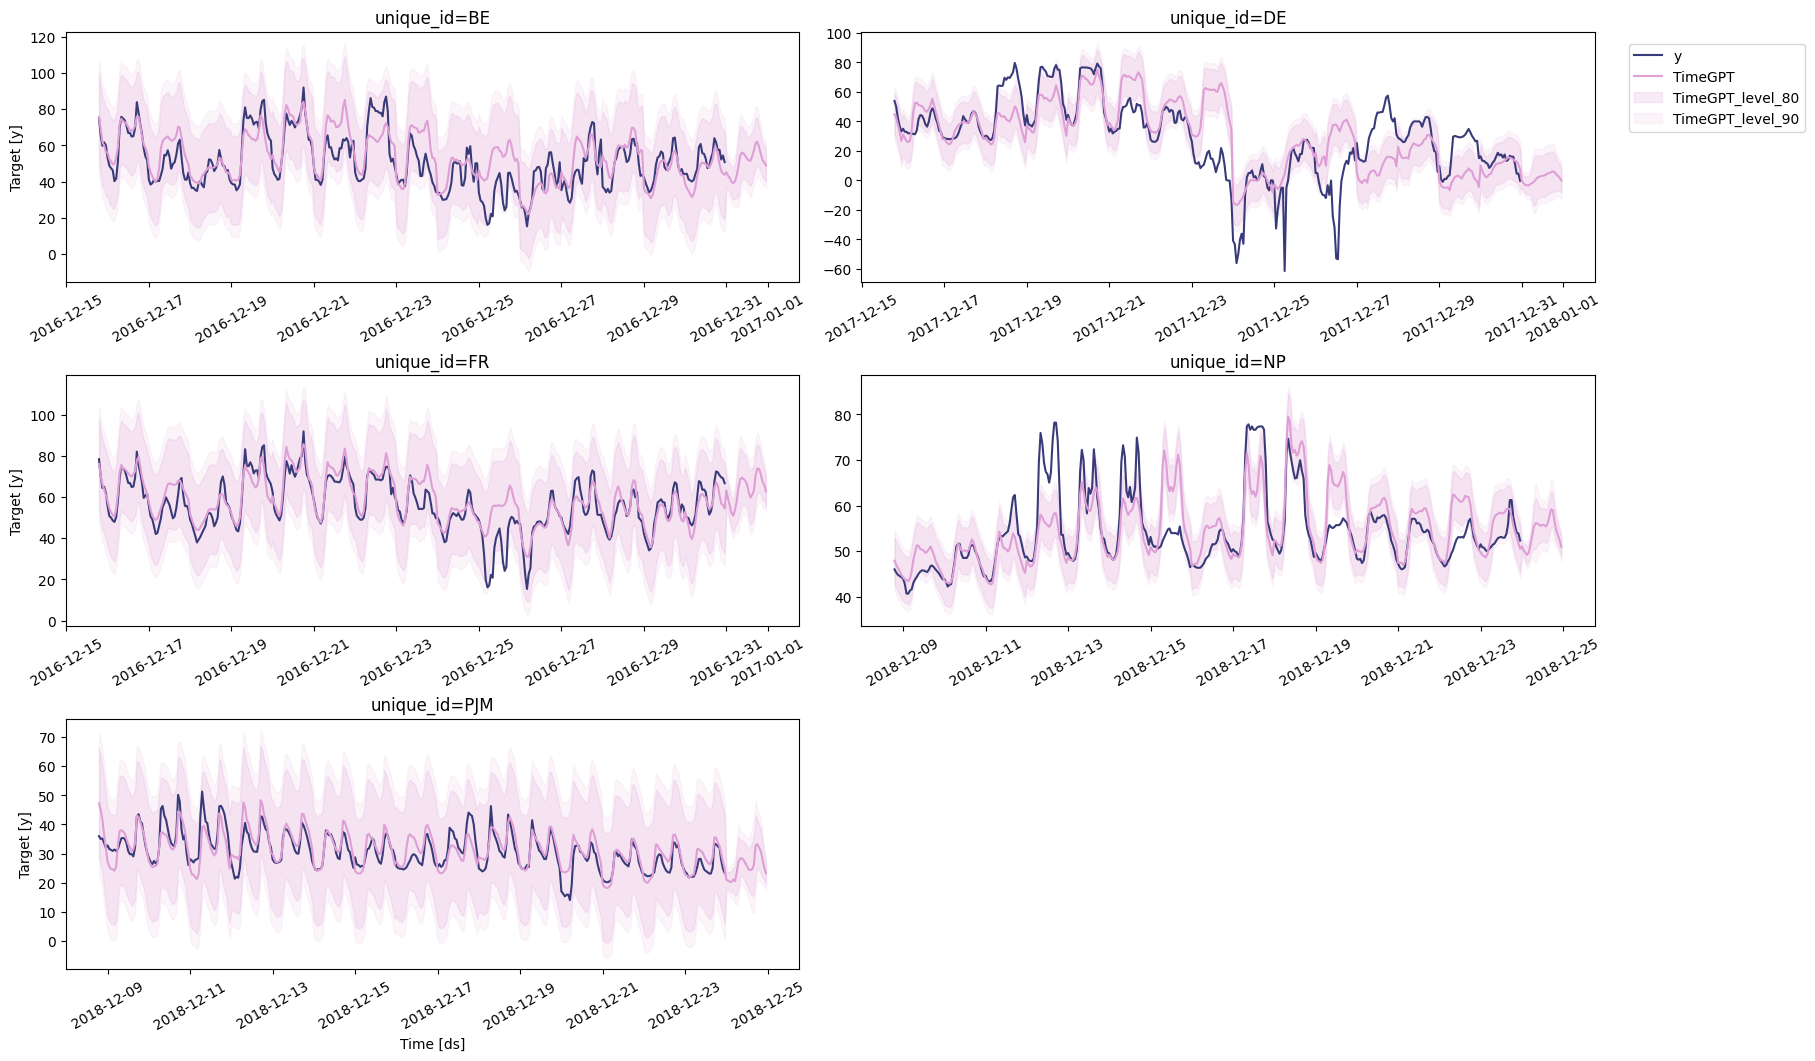

In [15]:
nixtla_client.plot(
    df,
    timegpt_fcst_multiseries_with_history_df.groupby('unique_id').tail(365 + 24),
    max_insample_length=365,
    level=[80, 90],
)

# **Long-Horizon forecasting**

### **Load Data**

In [16]:
Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')
Y_df.head()

100%|██████████| 314M/314M [00:11<00:00, 27.4MiB/s]


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


In [17]:
test = Y_df[-96:]
input_seq = Y_df[-1104:-96]

In [18]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

### **Forecasting for long-horizon**

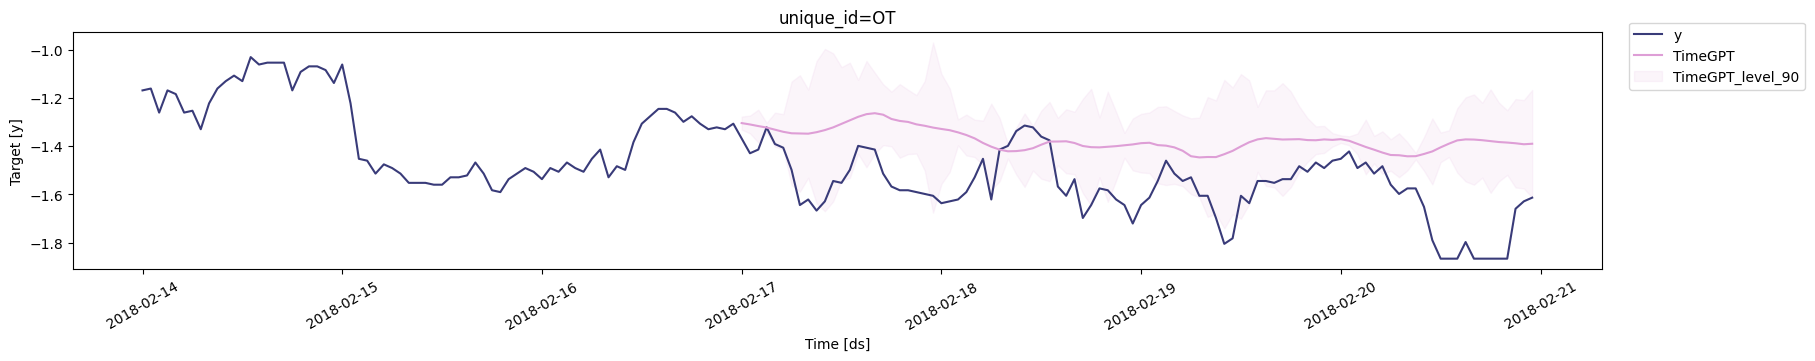

In [19]:
nixtla_client.plot(Y_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

### **Evaluation**

In [20]:
test = test.copy()
test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [21]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

In [22]:
print(evaluation)

  unique_id   TimeGPT
0        OT  0.205291
